# 0. Define functions and import packages

In [1]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_12656/3737874019.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Tokenizer

In [3]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [4]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [5]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [6]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [7]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

## Let's see what are stop word

In [8]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Load data

In [9]:
df = pd.read_excel("../../data/raw/DataCorpus_classfied_중분류_1차 연구.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [10]:
def add_type_column(df):
    ops = df.iloc[:, 5:]
    op_type = ops[ops.columns[1:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1
    )
    op_type=op_type.str.lower()
    df["op_type"] = op_type
    op_type = pd.DataFrame(op_type.unique(), columns=["op_type"])
    op_type["op_id"] = op_type.index
    op_type.to_excel("../../data/raw/op_type.xlsx")
    df = df.merge(op_type, how='left', on="op_type")
    df.to_excel("../../data/processed/corpora_w_op_type.xlsx")
    return df

In [11]:
df = add_type_column(df)
df['op_id']

0      0
1      1
2      2
3      0
4      3
      ..
181    4
182    4
183    4
184    4
185    4
Name: op_id, Length: 186, dtype: int64

# 1. Type count from raw data
 Visualize initail labelled data

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


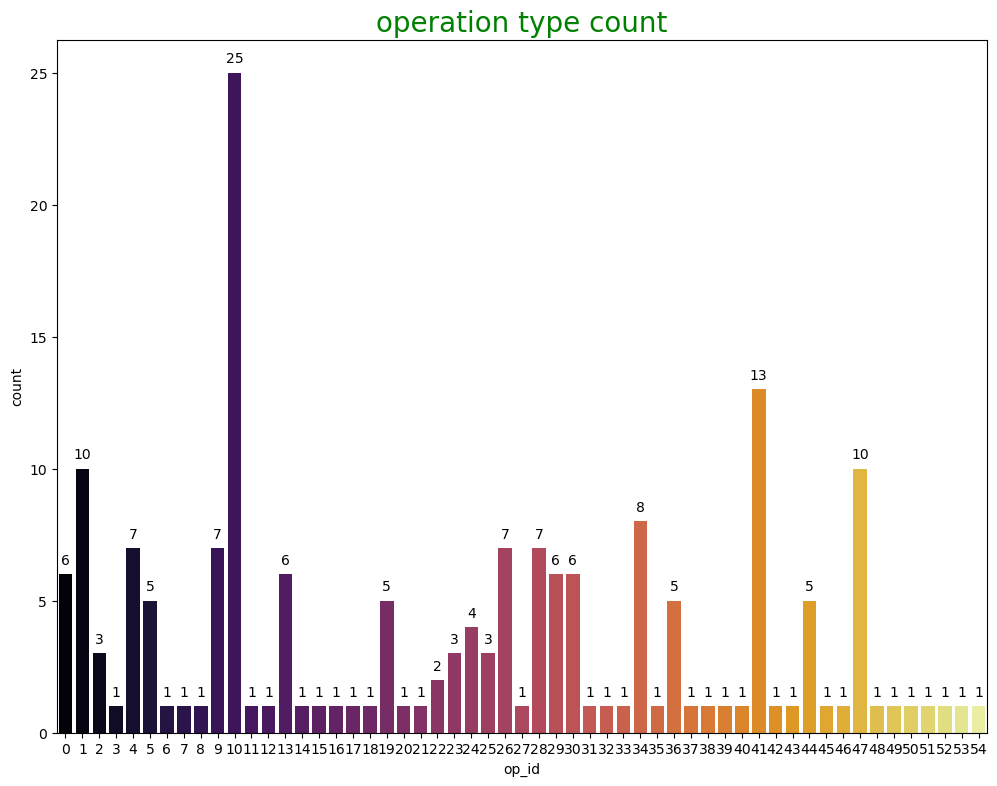

In [12]:
plt.figure(figsize=[12,9])
plot = sns.countplot(df["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
#plt.xticks(rotation=90)
plt.savefig("../../figures/class_and_count_initial.png", bbox_inches='tight')
plt.show()

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [13]:
df_drop_solo= df.groupby("op_id").filter(lambda x: len(x) >2)
df_drop_solo.to_excel("../../data/processed/corpora_unique_ops_dropped.xlsx")

In [14]:
df_drop_solo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 185
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Question       151 non-null    object 
 1   extents        151 non-null    object 
 2   upper level    18 non-null     object 
 3   timespan       4 non-null      object 
 4   Tag In Osm     93 non-null     object 
 5   Question type  151 non-null    object 
 6   ordinary1      151 non-null    object 
 7   ordinary2      141 non-null    object 
 8   ordinary3      115 non-null    object 
 9   ordinary4      54 non-null     object 
 10  ordinary5      33 non-null     object 
 11  ordinary6      10 non-null     object 
 12  ordinary7      5 non-null      object 
 13  ordinary8      0 non-null      object 
 14  ordinary9      0 non-null      object 
 15  ordinary10     0 non-null      object 
 16  ordinary103    0 non-null      object 
 17  ordinary102    0 non-null      object 
 18  ordinary11

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


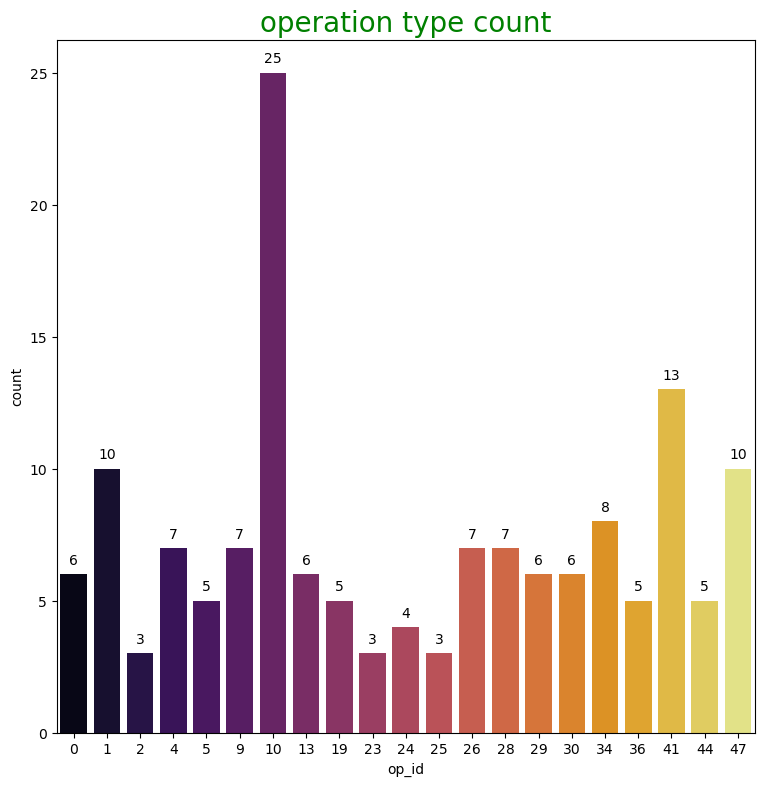

In [15]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig("../../figures/class_and_count_delete_unique.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

# 3. Paraphrase only some portion. 
 Stratified sampleing. fraction = 0.8 <br />
 At this point go to [paraphraser](../../utils/main_balanced.py) and run the script and come back here

In [16]:
tr_te_set = pd.read_excel("../../data/processed/train_test_only_paraphrased.xlsx")
print(tr_te_set)

     Unnamed: 0.1  Unnamed: 0  \
0               0           0   
1               1         168   
2               2          45   
3               3         151   
4               4         178   
..            ...         ...   
307           307         177   
308           308         179   
309           309         180   
310           310         183   
311           311         185   

                                              Question  \
0    how many buildings are within 3 minutes of dri...   
1    which houses are within 2 minutes driving time...   
2    what areas are within 15 minutes walking dista...   
3    where are forestry lands in happy valley ski r...   
4    which shops are open at 6 pm in happy valley s...   
..                                                 ...   
307  Which schools are not within 3 minutes of driv...   
308  Which vacant lots are within 1 mile of a freew...   
309   Which visitor facilities are in the Happy Valley   
310  Which wind farm pr

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


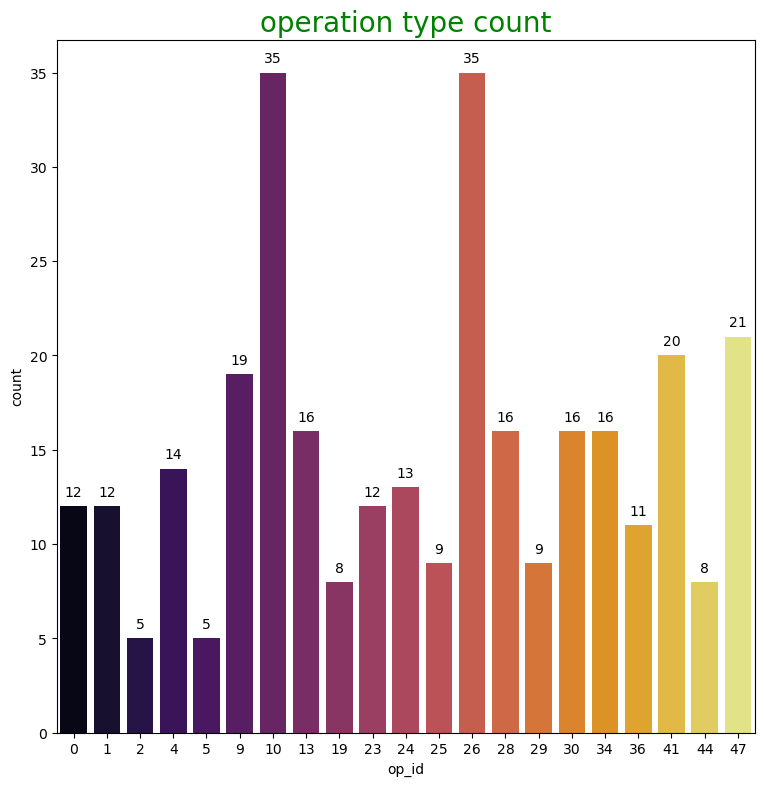

In [17]:
plt.figure(figsize=[9,9])
plot = sns.countplot(tr_te_set["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig("../../figures/class_and_count_delete_unique_and_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

# 4. Preprocessing

In [18]:
questions = tr_te_set["Question"].str.lower()
tr_or_test = tr_te_set["for train"]
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [19]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_lem = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
# questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 2
# print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


## 4.2 Vectorize with TfIdf

In [20]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(312, 366)

# 5. classify

In [21]:
tfidf = pd.DataFrame(features, columns = vectorizer.get_feature_names())
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question.to_excel("../../data/processed/tfidf_vectorized.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


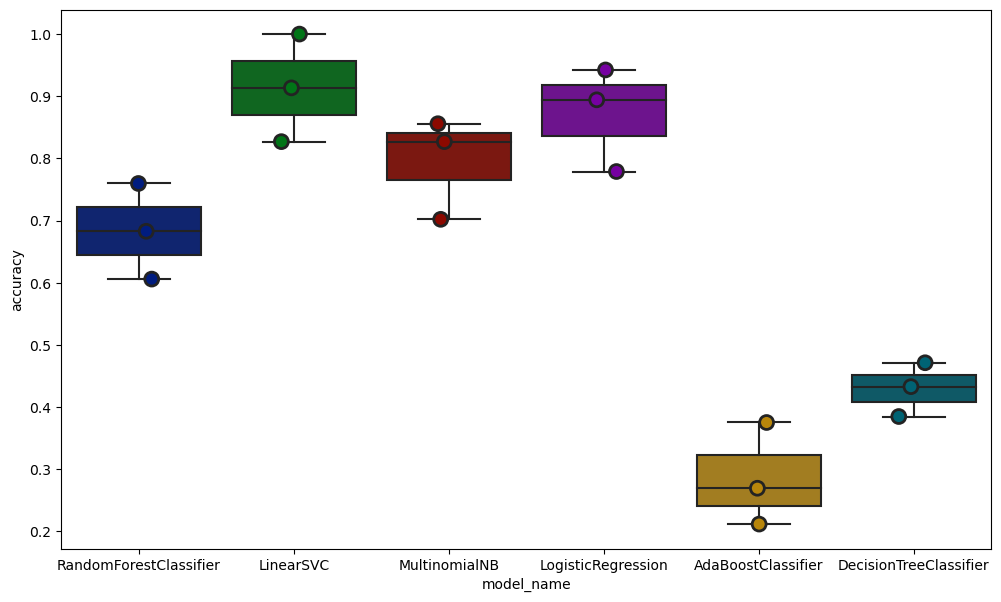

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    AdaBoostClassifier(),
    DecisionTreeClassifier(max_depth=5),
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/small_classification.png", bbox_inches='tight')
plt.show()

In [23]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
AdaBoostClassifier        0.285256
DecisionTreeClassifier    0.429487
LinearSVC                 0.913462
LogisticRegression        0.871795
MultinomialNB             0.794872
RandomForestClassifier    0.682692
Name: accuracy, dtype: float64

In [25]:
train_bool = tr_te_set["for train"]==True
test_bool = ~train_bool
X_train_q_tag = tfidf_w_question[train_bool]
X_test_q_tag = tfidf_w_question[~train_bool]
y_train = X_train_q_tag["op_id"]
y_test = X_test_q_tag["op_id"]
X_train = X_train_q_tag.drop(columns=["Question","processed_question","op_id"])
X_test = X_test_q_tag.drop(columns=["Question","processed_question","op_id"])
indices_train = y_train.index
indices_test = y_test.index

# Pick model and run

[0, 1, 2, 4, 5, 9, 10, 13, 19, 23, 24, 25, 26, 28, 29, 30, 34, 36, 41, 44, 47]


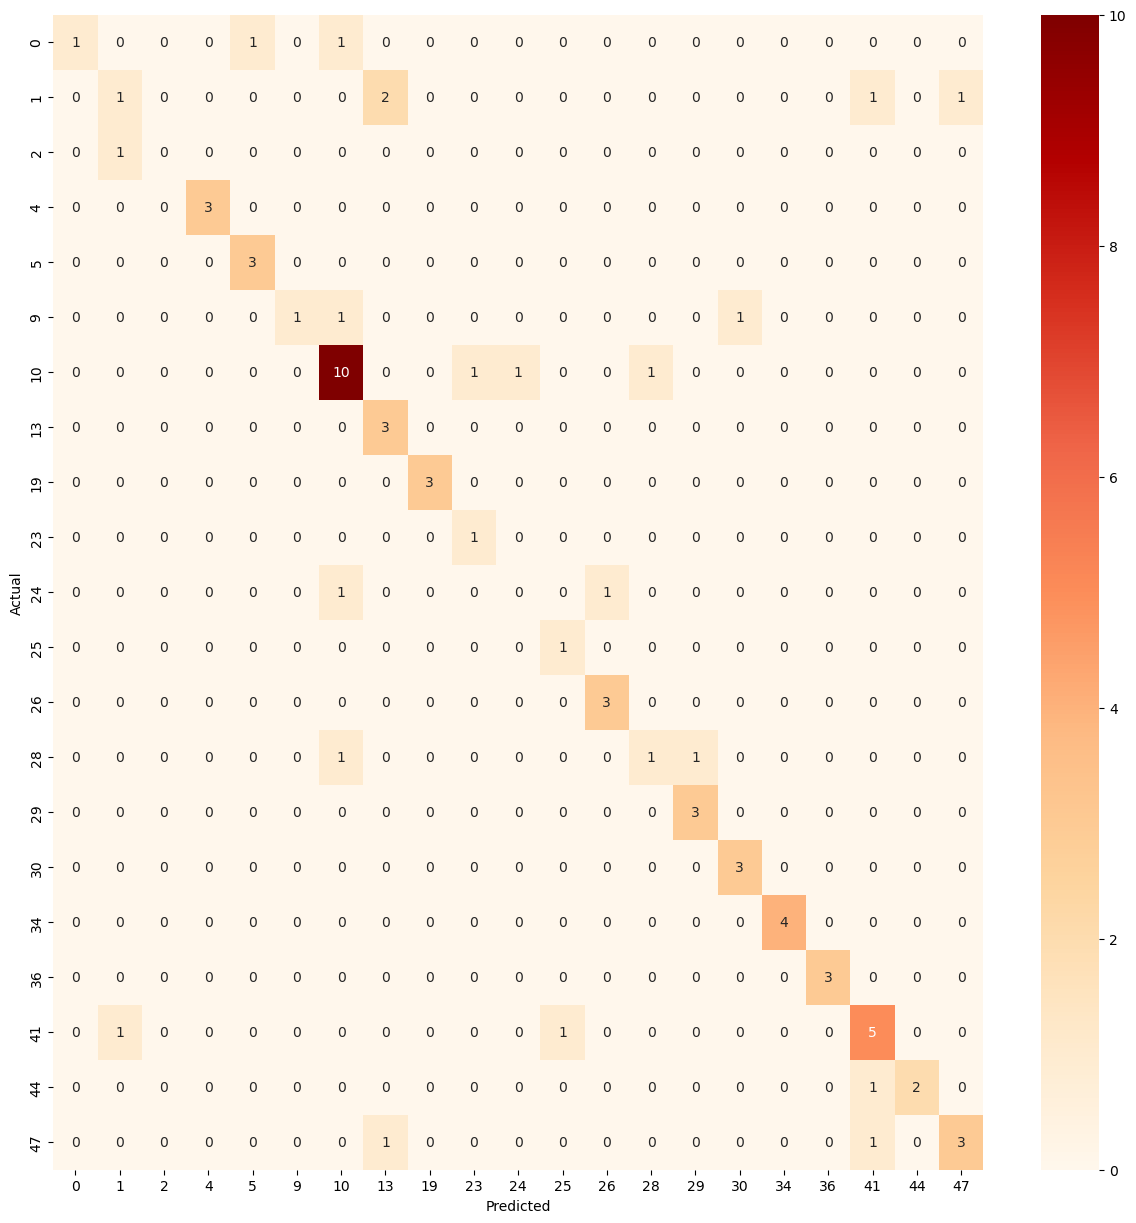

In [26]:
model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [27]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("../../data/processed/classification_report.xlsx")
print(report)

['0', '1', '2', '4', '5', '9', '10', '13', '19', '23', '24', '25', '26', '28', '29', '30', '34', '36', '41', '44', '47']
accuracy 0.72
{'0': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, '1': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 5}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3}, '5': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 3}, '9': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}, '10': {'precision': 0.7142857142857143, 'recall': 0.7692307692307693, 'f1-score': 0.7407407407407408, 'support': 13}, '13': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 3}, '19': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3}, '23': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1}, '24': {'prec

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Visualize w/ PCA, LDA & T-SNE

## LDA 
ㄹ벨이 있는 경우엔 이걸  쓰는게 맞음

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.manifold import TSNE


from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time

In [29]:
X = tfidf_w_question.drop(columns=["Question","processed_question","op_id"])
y = tfidf_w_question["op_id"]
target_names = y.unique()
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
df_x_r = pd.DataFrame(X_r)
df_x_r.columns = ["pca1","pca2"]
df_x_r["labels"] = y

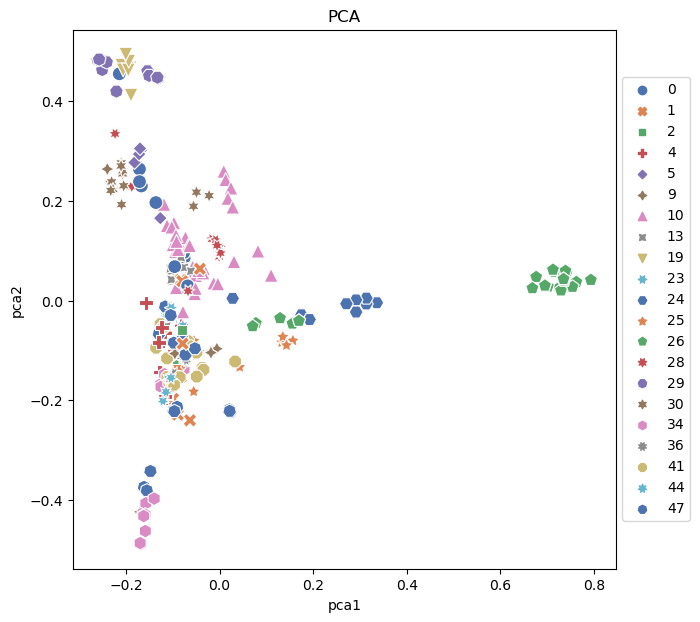

In [30]:
plt.figure(figsize=[7,7])
g= sns.scatterplot(data = df_x_r, x="pca1", y="pca2", hue="labels", style="labels", palette="deep", s=100)
plt.title("PCA")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)
plt.show()

In [31]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X,y).transform(X)
print(X_r2[0])
df_x_r2 = pd.DataFrame(X_r2)
df_x_r2.columns = ["pca1","pca2"]
df_x_r2["labels"] = y

[ 871.35163814 1346.60719493]


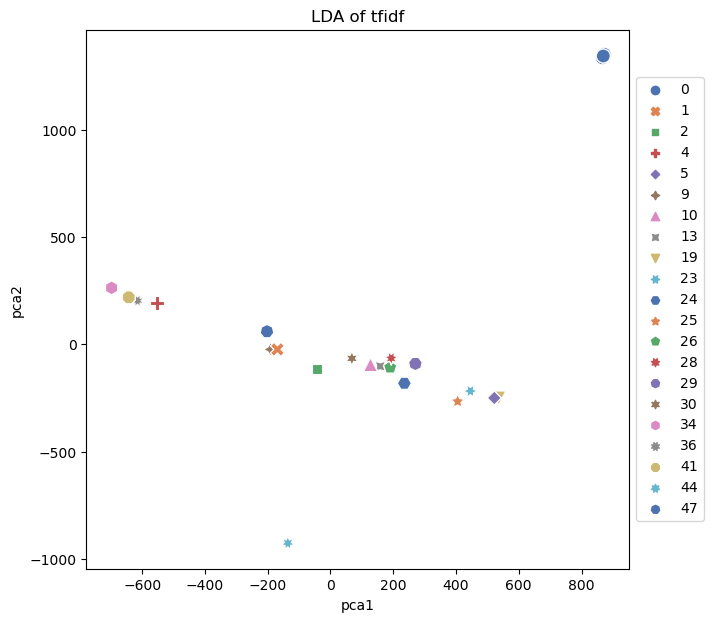

In [32]:
plt.figure(figsize=[7,7])
sns.scatterplot(data = df_x_r2, x="pca1", y="pca2", hue="labels",style="labels", palette="deep", s=100)
plt.title("LDA of tfidf")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)
plt.show()

## T-SNE

In [33]:
X_t_sne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_t_sne

array([[ 36.017452  ,   6.3059425 ],
       [ 38.58501   ,  14.748111  ],
       [ 60.872208  ,  21.14911   ],
       [ -0.21661639,  47.452934  ],
       [ -0.9721556 ,  55.859856  ],
       [  5.986563  ,  37.500965  ],
       [  6.400265  ,  44.53424   ],
       [  5.499713  ,  38.53561   ],
       [  6.001856  ,  30.411215  ],
       [ 39.122402  ,  -0.55432385],
       [ 33.73043   ,  10.010073  ],
       [ -6.909388  , -59.36229   ],
       [ -4.6082487 , -63.59077   ],
       [ -5.842625  , -64.24074   ],
       [ 34.856792  ,   9.9994755 ],
       [ 63.753395  ,   8.573527  ],
       [ 37.43145   , -47.050465  ],
       [-43.809643  ,  52.75564   ],
       [ 34.370354  , -14.523906  ],
       [ 27.262407  , -10.236119  ],
       [-21.338217  ,   3.2081325 ],
       [-13.485196  ,  12.839333  ],
       [-22.171253  ,   5.409839  ],
       [-22.054142  ,   6.9339705 ],
       [-13.335339  ,  13.107253  ],
       [-22.312828  ,   5.5697794 ],
       [-60.13938   ,   3.0987291 ],
 

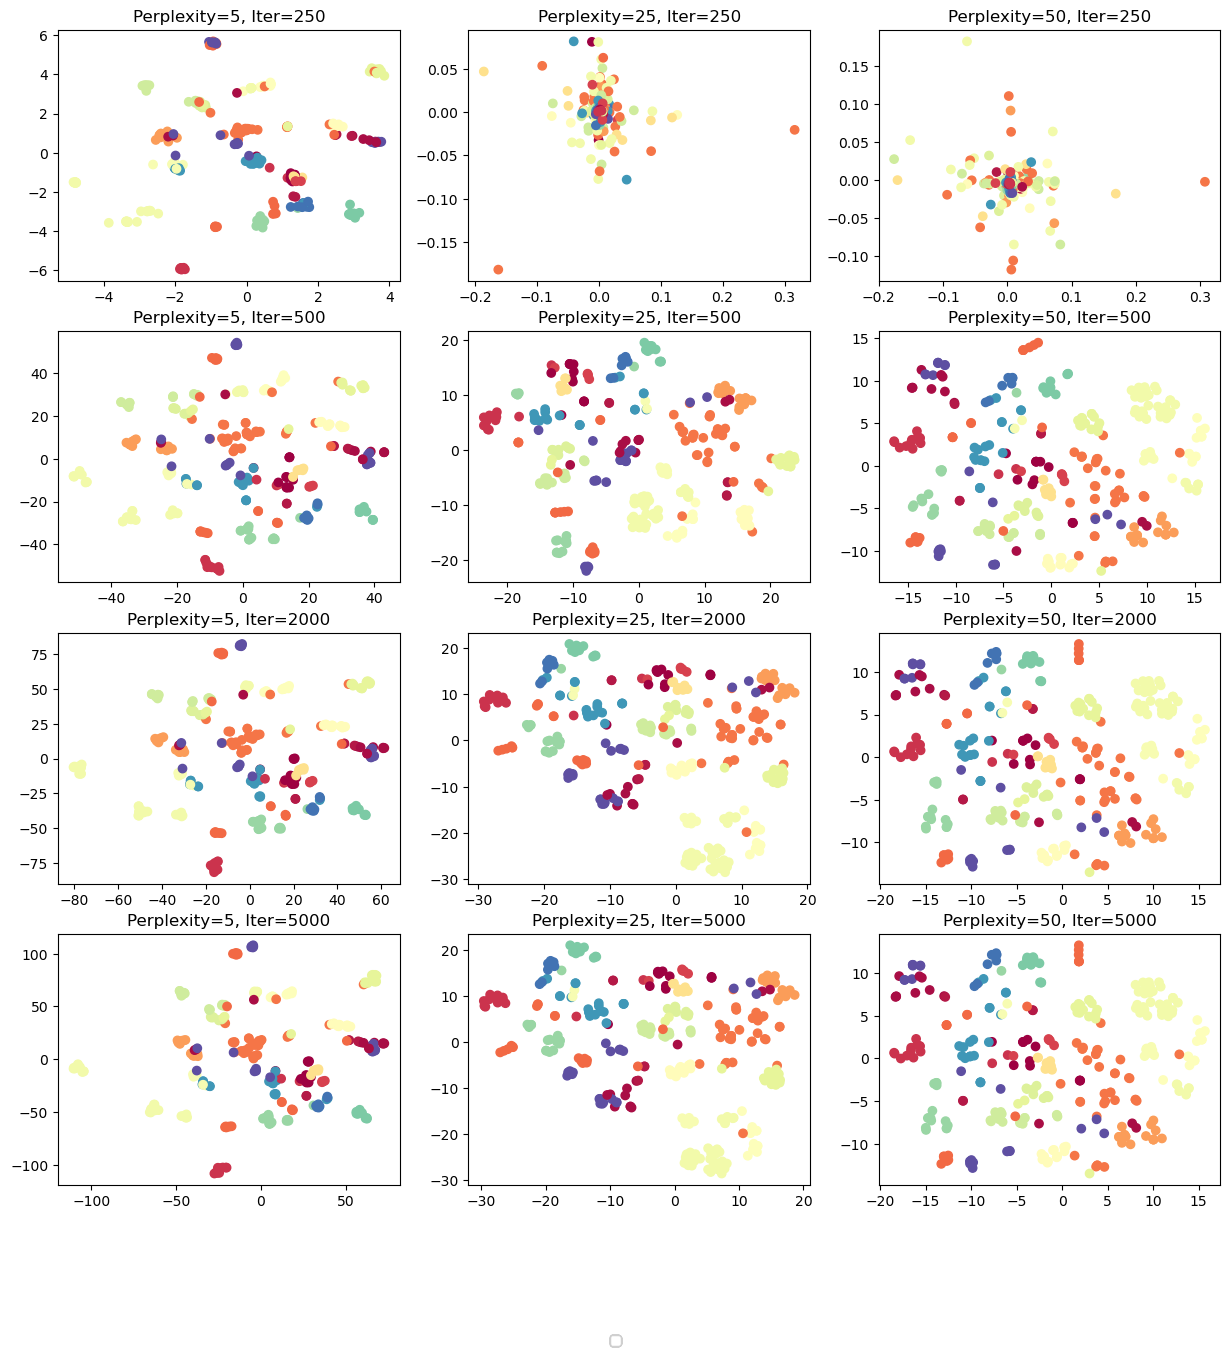

In [34]:
(fig, subplots) = plt.subplots(4, 3, figsize=(15,15))
perplexities = [5, 25, 50]
n_iters = [250,500,2000,5000]

for i, n_iter in enumerate(n_iters):
    for j, perplexity in enumerate(perplexities):
        ax=subplots[i][j]
        tsne = manifold.TSNE(
            n_components=2,
            init="random",
            random_state=235,
            perplexity=perplexity,
            learning_rate='auto',
            n_iter=n_iter,
        )
        Y = tsne.fit_transform(X)
        ax.set_title(f"Perplexity={str(perplexity)}, Iter={str(n_iter)}")
        ax.scatter(Y[:,0], Y[:, 1], c=y.to_numpy(), cmap="Spectral" )
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center")

plt.show()



## T-SNE final choice

In [35]:

tsne = manifold.TSNE(
            n_components=2,
            init="random",
            random_state=235,
            perplexity=50,
            learning_rate='auto',
            n_iter=5000,
)
Y = tsne.fit_transform(X)
t_sne_df = pd.DataFrame(Y)
t_sne_df.columns = ["x","y"]
t_sne_df["op_id"] = tfidf_w_question["op_id"]
t_sne_df["for train"] = tr_te_set["for train"]
t_sne_df["for train"] = t_sne_df["for train"].apply(lambda x : "Train set" if x == True else "Test set") 




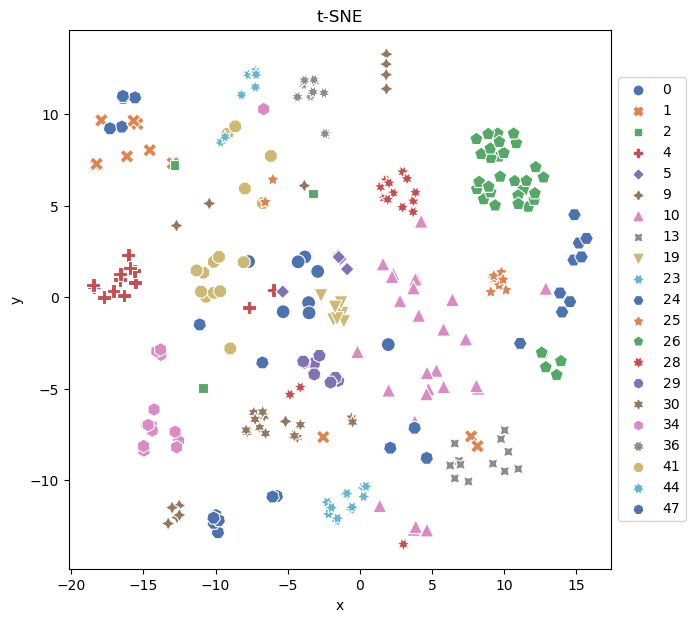

In [36]:
plt.figure(figsize=[7,7])

sns.scatterplot(data=t_sne_df, x="x", y="y", hue="op_id", style="op_id", palette="deep", s=100)


plt.title("t-SNE")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 700x700 with 0 Axes>

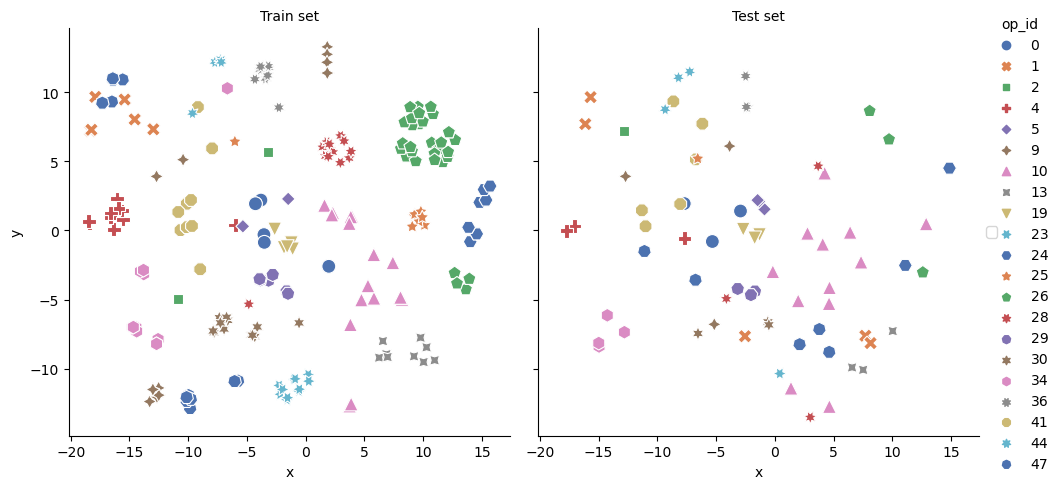

In [37]:
plt.figure(figsize=[7,7])

# sns.scatterplot(data=t_sne_df, x="x", y="y", hue="op_id", style="op_id", palette="deep", s=100)
sns.relplot(data=t_sne_df, x="x", y="y",
            col="for train", hue="op_id", style="op_id" ,
            palette="deep", s=100
).set_titles(col_template="{col_name}")

plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)

plt.show()